In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
def analytical_solution(x, t, Re):
    t0 = np.exp(Re / 8)
    numerator = x / (t + 1)
    denominator = 1 + np.sqrt((t + 1) / t0) * np.exp(Re * (x**2) / (4 * t + 4))
    return numerator / denominator

def generate_data(Re_values, x_points, t_points):
    data = []
    for Re in Re_values:
        for t in t_points:
            u_values = [analytical_solution(x, t, Re) for x in x_points]
            data.append({"Re": Re, "t": t, "x": x_points, "u": u_values})
    return data

# Parameters for Data Generation
Re_values = np.linspace(10, 100, 10)  # 10 values of Re
x_points = np.linspace(0, 1, 200)    # 200 spatial points
t_points = np.linspace(0, 2, 200)     # 200 time points

# Generate Dataset
data = generate_data(Re_values, x_points, t_points)

In [ ]:
def generate_data(Re_values, x_points, t_points):
    data = []
    for Re in Re_values:
        for t in t_points:
            u_values = [analytical_solution(x, t, Re) for x in x_points]
            data.append({"Re": Re, "t": t, "x": x_points, "u": u_values})
    return data

In [ ]:
# Prepare Input and Output
def prepare_data(data):
  X_branch = []  # Input to branch network (u(x, 0))
  X_trunk = []   # Input to trunk network ((x, t))
  y = []         # Target output (u(x, t))

  for entry in data:
      # Generate u(x, 0) for branch network input
      u_x0 = [analytical_solution(x, 0, entry["Re"]) for x in entry["x"]]
      for x, u_val in zip(entry["x"], entry["u"]):
          X_branch.append(u_x0)  # u(x, 0) for the entire spatial domain
          X_trunk.append([x, entry["t"]])  # (x, t) pair
          y.append(u_val)  # u(x, t)

  # Convert to NumPy arrays
  X_branch = np.array(X_branch, dtype=np.float32)
  X_trunk = np.array(X_trunk, dtype=np.float32)
  y = np.array(y, dtype=np.float32)

  # Train-Test Split
  X_branch_train, X_branch_test, X_trunk_train, X_trunk_test, y_train, y_test = train_test_split(
      X_branch, X_trunk, y, test_size=0.2, random_state=42
  )
  return X_branch_train, X_branch_test, X_trunk_train, X_trunk_test, y_train, y_test

In [ ]:
class DeepONet(nn.Module):
    def __init__(self, branch_dim, trunk_dim, output_dim=1):
        super(DeepONet, self).__init__()
        # Branch Network
        self.branch_net = nn.Sequential(
            nn.Linear(branch_dim, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 12)
        )
        # Trunk Network
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_dim, 12),
            nn.ReLU(),
            nn.Linear(12, 12),
            nn.ReLU(),
            nn.Linear(12, 12)
        )
        # Output Layer
        self.output_layer = nn.Linear(12, output_dim)

    def forward(self, branch_input, trunk_input):
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)
        combined = branch_output * trunk_output  # Element-wise product
        return self.output_layer(combined)

In [ ]:
# Prepare Data
X_branch_train, X_branch_test, X_trunk_train, X_trunk_test, y_train, y_test = prepare_data(data)

In [ ]:
# Training function
def train_model(X_branch, X_trunk, y, epochs=500, lr=1e-3):

    X_branch_train, X_branch_val, X_trunk_train, X_trunk_val, y_train, y_val = train_test_split(
    X_branch, X_trunk, y, test_size=0.2, random_state=42)

    branch_dim = X_branch_train.shape[1]
    trunk_dim = X_trunk_train.shape[1]

    # Initialize the model, optimizer, and loss function
    model = DeepONet(branch_dim, trunk_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    # Convert data to PyTorch tensors
    X_branch_train = torch.tensor(X_branch_train).clone().detach().requires_grad_(False)
    X_trunk_train = torch.tensor(X_trunk_train).clone().detach().requires_grad_(False)
    y_train = torch.tensor(y_train).clone().detach().requires_grad_(False).unsqueeze(1)

    X_branch_val = torch.tensor(X_branch_val).clone().detach().requires_grad_(False)
    X_trunk_val = torch.tensor(X_trunk_val).clone().detach().requires_grad_(False)
    y_val = torch.tensor(y_val).clone().detach().requires_grad_(False).unsqueeze(1)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X_branch_train, X_trunk_train)
        predictions = predictions.view(-1, 1)  # Ensure correct shape
        loss = criterion(predictions, y_train)
        loss.backward()
        optimizer.step()

        # Validate the model
        if epoch % 100 == 0 or epoch == epochs - 1:
            model.eval()
            with torch.no_grad():
                val_predictions = model(X_branch_val, X_trunk_val)
                val_predictions = val_predictions.view(-1, 1)  # Ensure correct shape
                val_loss = criterion(val_predictions, y_val)
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")

    return model

In [ ]:
model = train_model(X_branch_train, X_trunk_train, y_train)

Epoch 0, Train Loss: 0.0118, Validation Loss: 0.0114
Epoch 100, Train Loss: 0.0046, Validation Loss: 0.0046
Epoch 200, Train Loss: 0.0010, Validation Loss: 0.0010
Epoch 300, Train Loss: 0.0004, Validation Loss: 0.0004
Epoch 400, Train Loss: 0.0003, Validation Loss: 0.0003
Epoch 500, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 600, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 700, Train Loss: 0.0002, Validation Loss: 0.0002
Epoch 800, Train Loss: 0.0001, Validation Loss: 0.0001


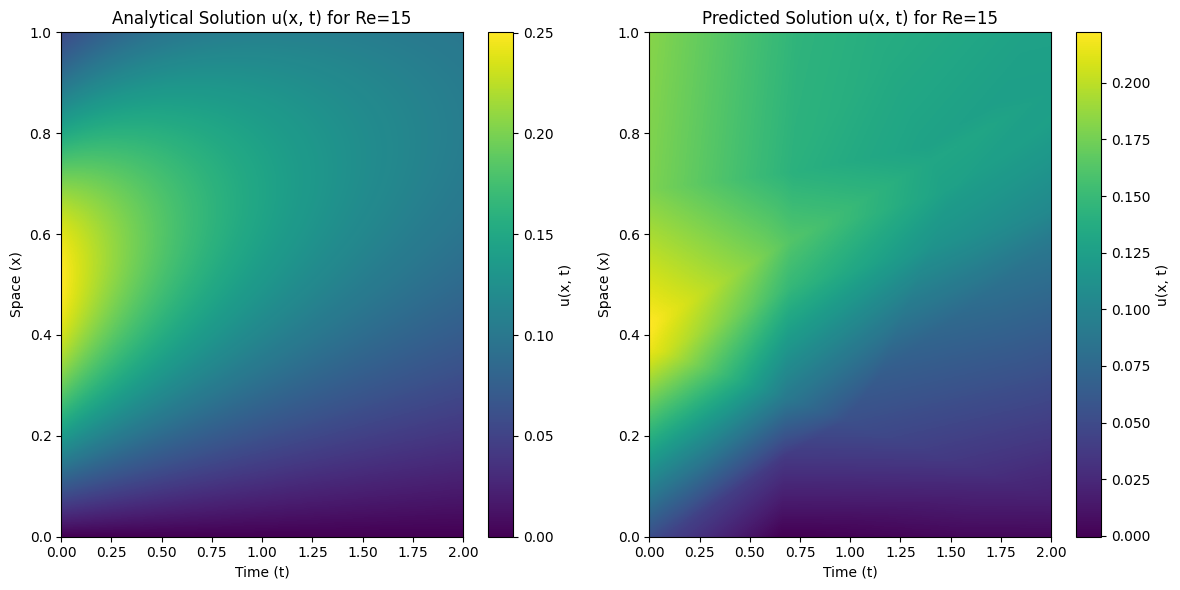

In [ ]:
# Example Parameters for Inference
Re_inference = 15  # Reynolds number for inference
x_inference = np.linspace(0, 1, 200)  # Spatial points
t_inference = np.linspace(0, 2, 200)  # Temporal points

# Generate Analytical Solution for the given Reynolds number
analytical_u = np.array([[analytical_solution(x, t, Re_inference) for t in t_inference] for x in x_inference])

# Generate u(x, 0) for the branch network input using the analytical solution
u_x0_inference = [analytical_solution(x, 0, Re_inference) for x in x_inference]

# Create input pairs (x, t) for the trunk network
X_trunk_inference = np.array([[x, t] for x in x_inference for t in t_inference], dtype=np.float32)

# Convert to PyTorch Tensors
u_x0_tensor = torch.tensor(u_x0_inference, dtype=torch.float32).unsqueeze(0).repeat(X_trunk_inference.shape[0], 1)
X_trunk_tensor = torch.tensor(X_trunk_inference, dtype=torch.float32)

# Assuming `model` is already defined and trained
# Predict with the model
model.eval()
with torch.no_grad():
    predictions = model(u_x0_tensor, X_trunk_tensor)

# Reshape Predictions for Visualization
predictions = predictions.numpy().reshape(len(x_inference), len(t_inference))  # Shape (100 x 50)

# Plot the Analytical Solution
plt.figure(figsize=(12, 6))

# Plot the Analytical Solution
plt.subplot(1, 2, 1)
plt.imshow(analytical_u, extent=[t_inference.min(), t_inference.max(), x_inference.min(), x_inference.max()],
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label="u(x, t)")
plt.title(f"Analytical Solution u(x, t) for Re={Re_inference}")
plt.xlabel("Time (t)")
plt.ylabel("Space (x)")

# Plot the Predicted Solution
plt.subplot(1, 2, 2)
plt.imshow(predictions, extent=[t_inference.min(), t_inference.max(), x_inference.min(), x_inference.max()],
           origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label="u(x, t)")
plt.title(f"Predicted Solution u(x, t) for Re={Re_inference}")
plt.xlabel("Time (t)")
plt.ylabel("Space (x)")

# Display the plot
plt.tight_layout()
plt.show()

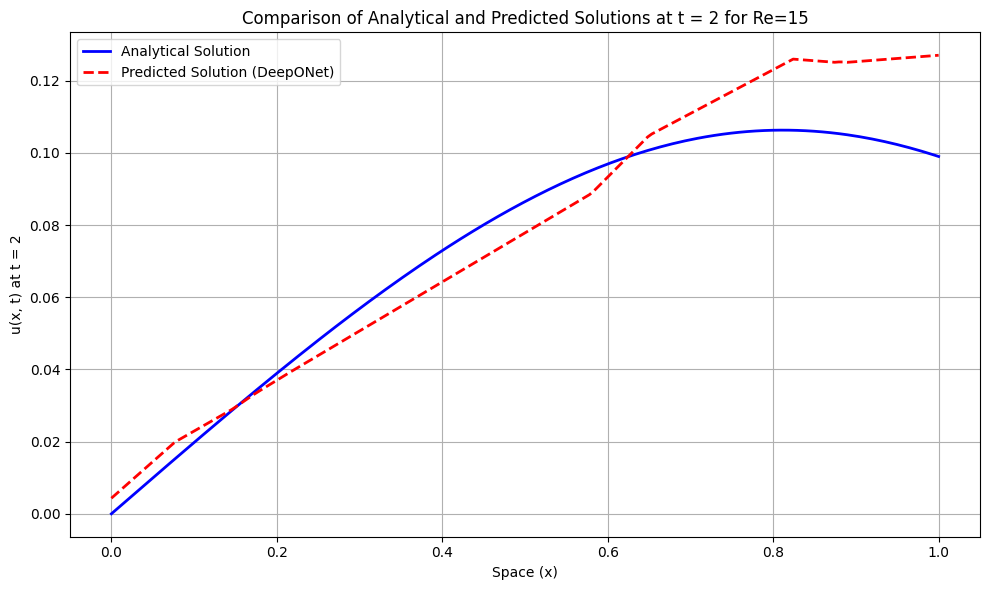

In [ ]:
# Select data for t = 1 for both the analytical and predicted solutions
t_specific = 2  # For instance, let's choose t = 2
t_index = np.argmin(np.abs(t_inference - t_specific))  # Find index closest to t = 2

analytical_at_t = analytical_u[:, t_index]  # Analytical solution at t = 2
predicted_at_t = predictions[:, t_index]  # Predicted solution at t = 2

# Plot the Analytical and Predicted Solutions for t = 2
plt.figure(figsize=(10, 6))

# Plot the Analytical Solution
plt.plot(x_inference, analytical_at_t, label="Analytical Solution", color='blue', linestyle='-', linewidth=2)

# Plot the Predicted Solution
plt.plot(x_inference, predicted_at_t, label="Predicted Solution (DeepONet)", color='red', linestyle='--', linewidth=2)

# Adding Labels and Legend
plt.xlabel("Space (x)")
plt.ylabel("u(x, t) at t = 2")
plt.title(f"Comparison of Analytical and Predicted Solutions at t = {t_specific} for Re={Re_inference}")
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, X_branch, X_trunk, y):
    # Convert inputs to tensors with no gradient tracking
    X_branch = torch.tensor(X_branch).clone().detach().requires_grad_(False)
    X_trunk = torch.tensor(X_trunk).clone().detach().requires_grad_(False)
    y = torch.tensor(y).clone().detach().requires_grad_(False).unsqueeze(1)

    # Predict using the model
    y_pred = model(X_branch, X_trunk)

    # Detach y_pred from the computation graph and convert to NumPy array
    y_pred_np = y_pred.detach().numpy()

    # Calculate Mean Squared Error
    mse = np.mean((y_pred_np - y.numpy()) ** 2)
    return mse

In [ ]:
mse = evaluate_model(model, X_branch_test, X_trunk_test, y_test)
print(f"Mean Squared Error on Test Data: {mse:.4f}")

Mean Squared Error on Test Data: 0.0002


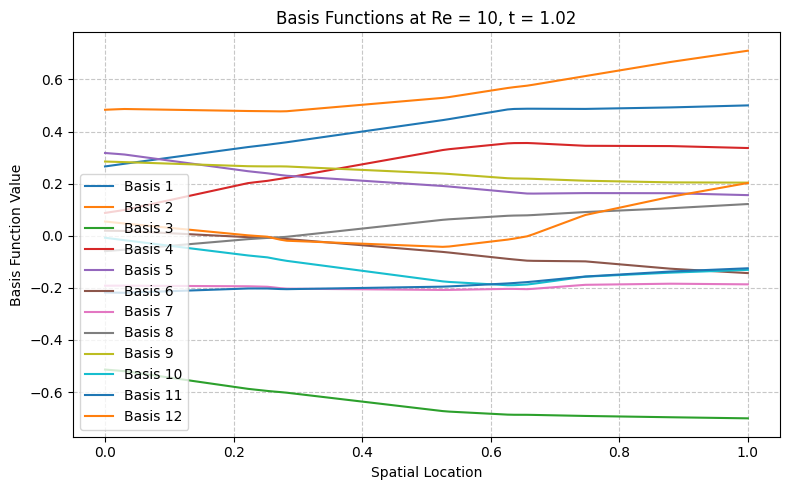

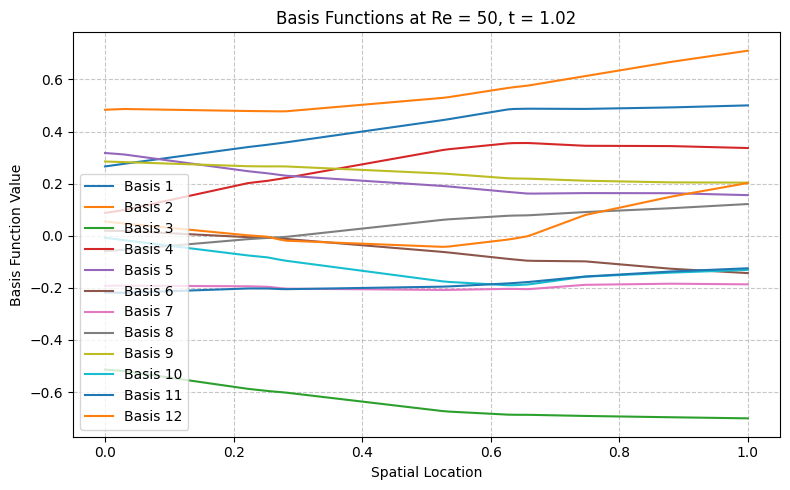

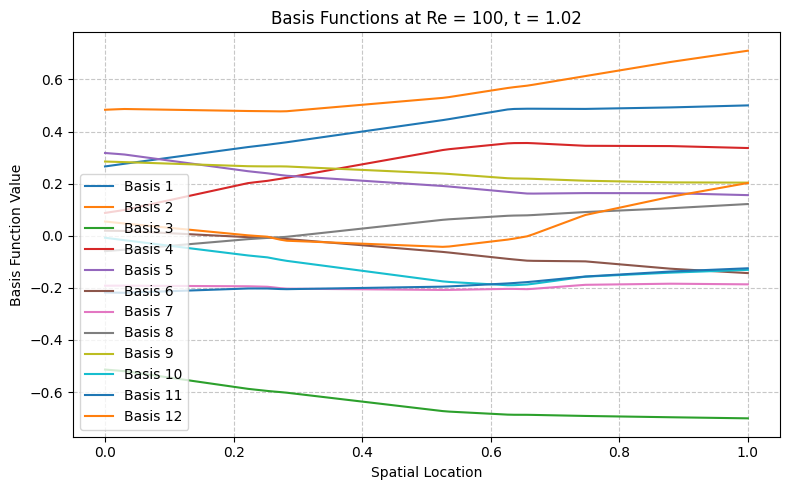

In [ ]:
reynolds_numbers = [10, 50, 100]

for reynlod_num in reynolds_numbers:
    Re_inference = reynlod_num  # Reynolds number for inference
    x_inference = np.linspace(0, 1, 100)  # Spatial points
    t_inference = np.linspace(0, 2, 50)  # Temporal points

    # Generate u(x, 0) for the branch network input using the analytical solution
    u_x0_inference = [analytical_solution(x, 0, Re_inference) for x in x_inference]

    # Create input pairs (x, t) for the trunk network
    X_trunk_inference = np.array([[x, t] for x in x_inference for t in t_inference], dtype=np.float32)

    # Convert to PyTorch Tensors
    u_x0_tensor = torch.tensor(u_x0_inference, dtype=torch.float32).unsqueeze(0).repeat(X_trunk_inference.shape[0], 1)
    X_trunk_tensor = torch.tensor(X_trunk_inference, dtype=torch.float32)

    # Predict with the model
    model.eval()
    with torch.no_grad():
        trunk_outputs = model.trunk_net(X_trunk_tensor)

    # Visualize basis functions
    trunk_outputs_reshaped = trunk_outputs.reshape(len(x_inference), len(t_inference), -1)

    # Plot basis functions at middle time step
    plt.figure(figsize=(8, 5))
    mid_time_index = len(t_inference) // 2
    for j in range(trunk_outputs_reshaped.shape[2]):
        basis_at_mid_time = trunk_outputs_reshaped[:, mid_time_index, j]
        plt.plot(x_inference, basis_at_mid_time, label=f'Basis {j+1}')

    plt.title(f'Basis Functions at Re = {Re_inference}, t = {t_inference[mid_time_index]:.2f}')
    plt.xlabel('Spatial Location')
    plt.ylabel('Basis Function Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [ ]:
# All high
Re_values = np.linspace(10, 100, 10) # 10 Re values
x_points = np.linspace(0, 1, 200)    # 200 spatial points
t_points = np.linspace(0, 2, 200)     # 200 time points

# Generate Dataset
data = generate_data(Re_values, x_points, t_points)

# Prepare Data
X_branch_train, X_branch_test, X_trunk_train, X_trunk_test, y_train, y_test = prepare_data(data)

# Train Model
model = train_model(X_branch_train, X_trunk_train, y_train)

# Evaluate Model
mse = evaluate_model(model, X_branch_test, X_trunk_test, y_test)
print(f"Mean Squared Error on Test Data: {mse:.4f}")

Epoch 0, Train Loss: 0.0385, Validation Loss: 0.0372
Epoch 100, Train Loss: 0.0052, Validation Loss: 0.0052
Epoch 200, Train Loss: 0.0027, Validation Loss: 0.0026
Epoch 300, Train Loss: 0.0010, Validation Loss: 0.0010
Epoch 400, Train Loss: 0.0005, Validation Loss: 0.0005
Epoch 499, Train Loss: 0.0004, Validation Loss: 0.0004
Mean Squared Error on Test Data: 0.0004


In [ ]:
# Less x_points
Re_values = np.linspace(10, 100, 10) # 10 Re values
x_points = np.linspace(0, 1, 100)    # 100 spatial points
t_points = np.linspace(0, 2, 200)     # 200 time points

# Generate Dataset
data = generate_data(Re_values, x_points, t_points)

# Prepare Data
X_branch_train, X_branch_test, X_trunk_train, X_trunk_test, y_train, y_test = prepare_data(data)

# Train Model
model = train_model(X_branch_train, X_trunk_train, y_train)

# Evaluate Model
mse = evaluate_model(model, X_branch_test, X_trunk_test, y_test)
print(f"Mean Squared Error on Test Data: {mse:.4f}")

Epoch 0, Train Loss: 0.0890, Validation Loss: 0.0866
Epoch 100, Train Loss: 0.0056, Validation Loss: 0.0056
Epoch 200, Train Loss: 0.0031, Validation Loss: 0.0030
Epoch 300, Train Loss: 0.0012, Validation Loss: 0.0012
Epoch 400, Train Loss: 0.0009, Validation Loss: 0.0009
Epoch 499, Train Loss: 0.0005, Validation Loss: 0.0005
Mean Squared Error on Test Data: 0.0005


In [ ]:
# Less t_points
Re_values = np.linspace(10, 100, 10) # 10 Re values
x_points = np.linspace(0, 1, 200)    # 200 spatial points
t_points = np.linspace(0, 2, 100)     # 100 time points

# Generate Dataset
data = generate_data(Re_values, x_points, t_points)

# Prepare Data
X_branch_train, X_branch_test, X_trunk_train, X_trunk_test, y_train, y_test = prepare_data(data)

# Train Model
model = train_model(X_branch_train, X_trunk_train, y_train)

# Evaluate Model
mse = evaluate_model(model, X_branch_test, X_trunk_test, y_test)
print(f"Mean Squared Error on Test Data: {mse:.4f}")

Epoch 0, Train Loss: 0.0988, Validation Loss: 0.0970
Epoch 100, Train Loss: 0.0061, Validation Loss: 0.0060
Epoch 200, Train Loss: 0.0040, Validation Loss: 0.0039
Epoch 300, Train Loss: 0.0022, Validation Loss: 0.0022
Epoch 400, Train Loss: 0.0013, Validation Loss: 0.0013
Epoch 499, Train Loss: 0.0011, Validation Loss: 0.0011
Mean Squared Error on Test Data: 0.0011


In [ ]:
# Less Re_values
Re_values = np.linspace(10, 50, 10) # 5 Re values
x_points = np.linspace(0, 1, 200)    # 200 spatial points
t_points = np.linspace(0, 2, 200)     # 200 time points

# Generate Dataset
data = generate_data(Re_values, x_points, t_points)

# Prepare Data
X_branch_train, X_branch_test, X_trunk_train, X_trunk_test, y_train, y_test = prepare_data(data)

# Train Model
model = train_model(X_branch_train, X_trunk_train, y_train)

# Evaluate Model
mse = evaluate_model(model, X_branch_test, X_trunk_test, y_test)
print(f"Mean Squared Error on Test Data: {mse:.4f}")

Epoch 0, Train Loss: 0.0734, Validation Loss: 0.0716
Epoch 100, Train Loss: 0.0036, Validation Loss: 0.0036
Epoch 200, Train Loss: 0.0026, Validation Loss: 0.0026
Epoch 300, Train Loss: 0.0015, Validation Loss: 0.0015
Epoch 400, Train Loss: 0.0008, Validation Loss: 0.0008
Epoch 499, Train Loss: 0.0007, Validation Loss: 0.0007
Mean Squared Error on Test Data: 0.0007
